In [1]:
import pkg_resources as pkg

path = pkg.resource_filename(__name__, "../")

import os

os.chdir(path)

/tmp/ipykernel_270156/3297475300.py:3: DeprecationWarning: Use of .. or absolute path in a resource path is not allowed and will raise exceptions in a future release.
  path = pkg.resource_filename(__name__, "../")


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from physioex.explain.bands import FreqBandsExplainer
from loguru import logger

ckp_path = "models/cel/chambon2018/seqlen=3/dreem/dodh/"

expl = FreqBandsExplainer(
    model_name="chambon2018",
    dataset_name="dreem",
    version="dodh",
    use_cache=True,
    sequence_lenght=3,
    ckp_path=ckp_path,
    batch_size=32,
)

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
/home/guido/miniconda3/envs/physioex/lib/python3.10/site-packages/moabb/pipelines/__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(
/home/guido/miniconda3/envs/physioex/lib/python3.10/site-packages/braindecode/preprocessing/preprocess.py:55: UserW

In [3]:
sleep_bands = [[0.5, 4], [4, 8], [8, 11.5], [11.5, 15.5], [15.5, 30], [30, 49.5]]
sleep_bands_names = ["Delta", "Theta", "Alpha", "Sigma", "Beta", "Gamma"]

expl.explain(
    sleep_bands,
    sleep_bands_names,
    plot_pred=False,
    plot_true=False,
    compute_time=True,
    save=True,
)

2024-03-01 18:49:15.441 | INFO     | physioex.explain.bands.explainer:compute_band_importance:116 - JOB:2-Loading model <class 'physioex.train.networks.chambon2018.Chambon2018Net'> from checkpoint models/cel/chambon2018/seqlen=3/dreem/dodh/fold=2-epoch=16-step=9880-val_acc=0.86.ckpt
2024-03-01 18:49:16.094 | INFO     | physioex.explain.bands.explainer:compute_band_importance:128 - JOB:2-Splitting dataset into train, validation and test sets
2024-03-01 18:49:16.443 | INFO     | physioex.data.dreem:split:205 - Train shape X (19028, 1, 3000), y (19028,)
2024-03-01 18:49:16.446 | INFO     | physioex.data.dreem:split:206 - Valid shape X (4039, 1, 3000), y (4039,)
2024-03-01 18:49:16.447 | INFO     | physioex.data.dreem:split:207 - Test shape X (1595, 1, 3000), y (1595,)
2024-03-01 18:49:18.396 | INFO     | physioex.explain.bands.explainer:compute_band_importance:145 - JOB:2-Computing bands importance
  0%|          | 2/595 [01:50<9:05:14, 55.17s/it]
2024-03-01 18:51:08.758 | INFO     | phys

KeyboardInterrupt: 

In [21]:
import torch
from physioex.explain.bands.importance import eXpDataset
import seaborn as sns
import numpy as np

exp = torch.load("models/cel/chambon2018/seqlen=3/dreem/dodh/explanations_fold_2.pt")

In [8]:
time_explanations.shape

(3, 1, 3000, 6, 5)

/tmp/ipykernel_270156/1721145748.py:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


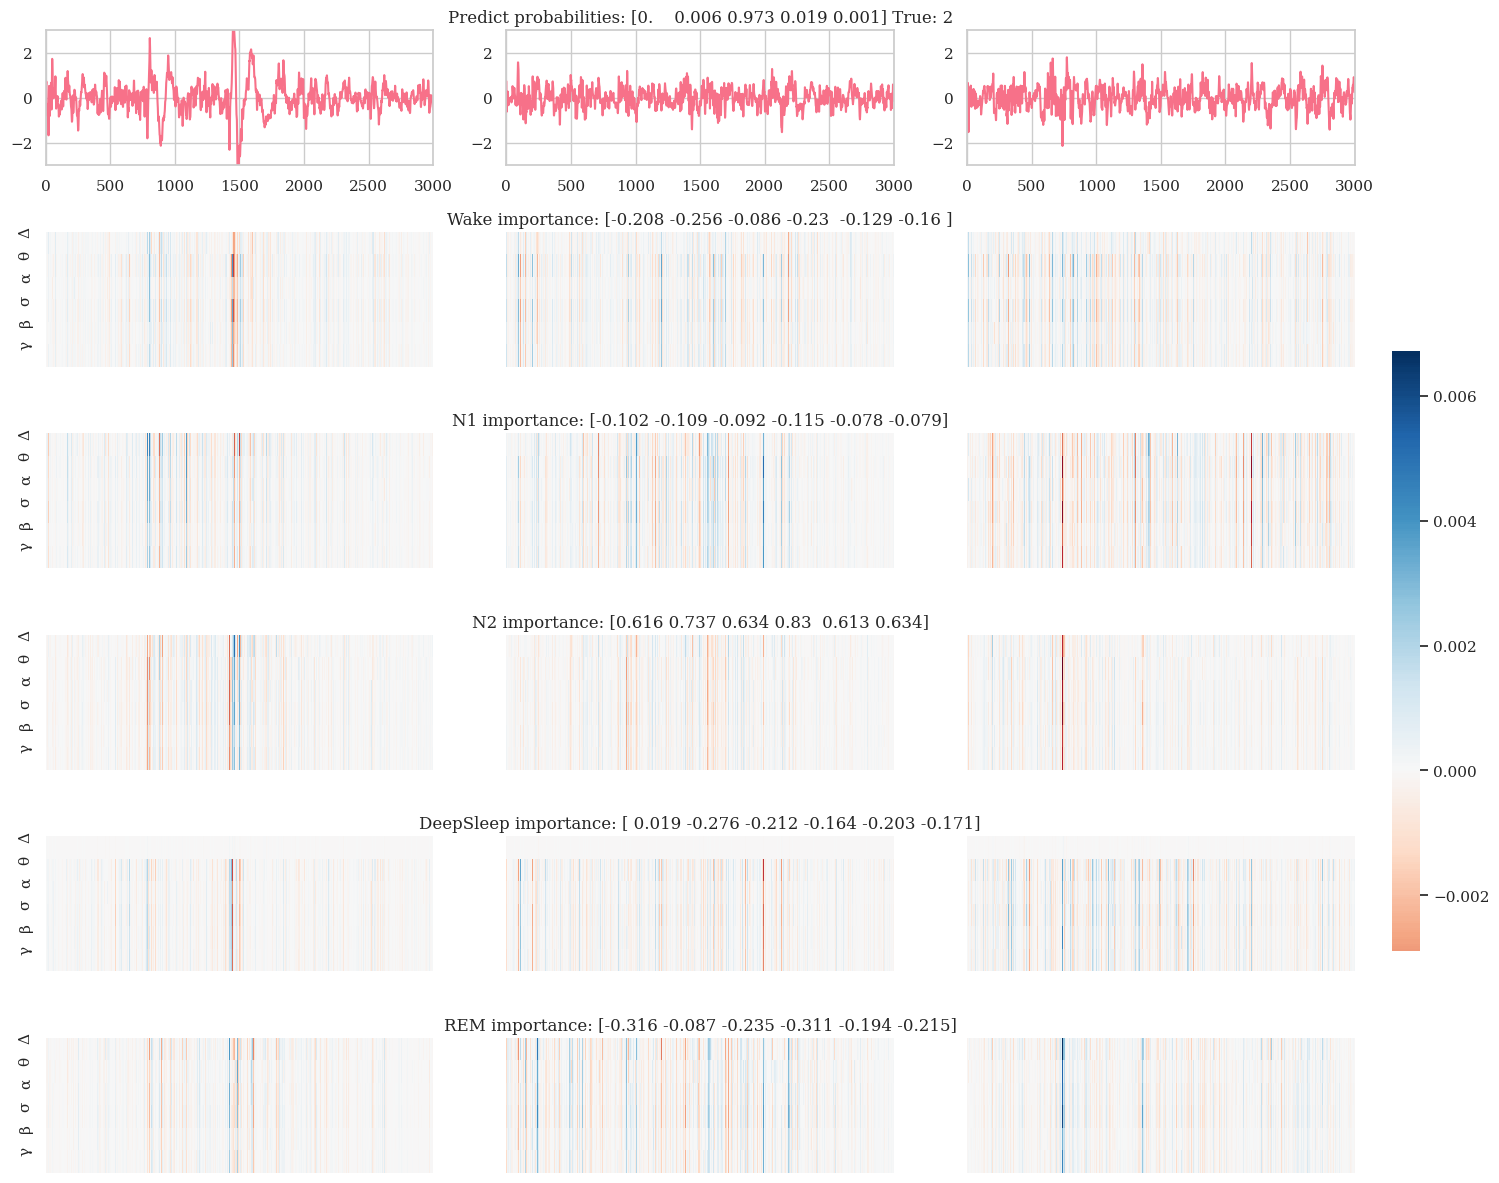

In [29]:
idx = 3

time_explanations = exp.time[idx]
probas = exp.probas[idx]
input = exp.inputs[idx].squeeze()

band_importances = exp.bands[idx]

time_explanations = time_explanations.squeeze()

seqlen, num_samples, num_bands, num_classes = time_explanations.shape

class_names = ["Wake", "N1", "N2", "DeepSleep", "REM"]
band_names = ["Δ", "θ", "α", "σ", "β", "γ"]

fig, axs = plt.subplots(
    num_classes + 1, seqlen, figsize=(14, 12)
)  # Dimensioni A4 in pollici

for i in range(seqlen):
    sns.lineplot(input[i], ax=axs[0, i])
    axs[0, i].set(ylim=(-3, 3), xlim=(0, 3000))

axs[0, 1].set_title(
    "Predict probabilities: "
    + str(np.round(probas, 3))
    + " True: "
    + str(exp.targets[idx])
)


# Create a common colorbar for all subplots
cbar_ax = fig.add_axes(
    [1, 0.2, 0.02, 0.5]
)  # Adjust the position and size of the colorbar

for i in range(num_classes):
    i = i + 1
    for j in range(seqlen):
        # Prendi il j-esimo campione per la i-esima classe
        sample = time_explanations[j, :, :, i - 1].transpose(1, 0)

        # Crea un heatmap di tempo-frequenza
        sns.heatmap(
            sample, ax=axs[i, j], cmap="RdBu", cbar_ax=cbar_ax, center=0
        )  # Add colorbar and center at 0

        if j == 1:
            axs[i, j].set_title(
                class_names[i - 1]
                + " importance: "
                + str(np.round(band_importances[:, i - 1], 3))
            )

        if j == 0:
            axs[i, j].set_yticks(range(len(band_names)))
            axs[i, j].set_yticklabels(
                band_names
            )  # Use Greek symbols for the band names
        else:
            axs[i, j].set_yticks([])

        axs[i, j].set_xticks([])

plt.tight_layout()
plt.show()